In [7]:
# the file imports_workshop.ipynb should be in the same directory as this notebook. Run this for all necessary imports.
%run imports_workshop.ipynb

# Exoplanets system architecture

This is a tutorial on how to use the uio-exoplanet-group Python package (https://uio.decovar.dev) and the scripts for assembling a statistically meaningful sample of the known exoplanets and exoplanetary systems.

The code in the cells helps you to understand how this set of scripts works in detail.


## Preparing the sample

The Python module `uio.task` from [uio-exoplanet-group](https://github.com/retifrav/uio-exoplanet-group) (see the documentation [here](https://uio.decovar.dev)) is used to prepare the sample.

For retrieving information from databases initially we need a list of potentially interesting systems, which can be formed using the `1-get-systems-with-more-than-planets.py` script.

This script allows to retrieve of star names for the systems, where at least two planets have both mass and radius defined, by fetching the parameter `star_name` from the NASA database. The results will be output to the file `systems.txt` file in the current directory, which then could be edited manually if you already know what system you want to exclude to save some processing time.

We encourage you to try this in the terminal. Edit the script to change the parameters of the search, like the number of planets in the system.

``` sh
$ python ./1-get-systems-with-more-than-planets.py
```

But the cell below shows you a fast* example of how you can use this code:

###### *fast because we want to find systems with at least 7 planets and specific star mass.



In [8]:
from uio.utility.databases import tap

serviceEndpoint = tap.getServiceEndpoint("NASA")
if not serviceEndpoint:
    raise SystemError(
        "[ERROR] Couldn't get a TAP endpoint for the specified service"
    )

resultPlanets = tap.queryService(
    serviceEndpoint,
    " ".join((
        "SELECT hostname",
        "FROM ps",
        "GROUP BY hostname",
    #    "WHERE st_mass BETWEEN 0.08 AND 1.2", # we could add conditions to the query at this step
        "HAVING COUNT(DISTINCT pl_name) > 6",
        "ORDER BY hostname"
    ))
).to_table().to_pandas()
display(resultPlanets)
with open("./systems.txt", "w") as f:
    f.write("\n".join(resultPlanets["hostname"].values))
    f.write("\n")

,hostname
0,KOI-351
1,TRAPPIST-1


For retrieving the partial information about the system in interest, you can run `2-task-manager-mass-radius.sh`. It will work through the planetary system list in `systems.txt` using `2-mass-radius-only-from-NASA.py` script and will write a pickle file for each system to `./data/star_pickles/`:

``` sh
$ chmod +x ./2-task-manager-mass-radius.sh
$ ./2-task-manager-mass-radius.sh
```

You can change the parameters of choise, in this case mass and radius for other parameters of interest like eccentrisity or orbital period.
You also can run the cell below to see how we retrieve this data for mass and radius for our sample of >5 planet systems:

In [9]:
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support

from uio.utility.databases import tap


serviceNameNASA = "NASA"
if not tap.services.get(serviceNameNASA):
    raise SystemExit(f"The list of services doesn't have {serviceNameNASA}")
serviceEndpointNASA = tap.getServiceEndpoint(serviceNameNASA)
# Go ahead and change the parameters using the parameter space in there:  https://exoplanetarchive.ipac.caltech.edu/docs/API_PS_columns.html
dictForCheckingPlanet = {
    "pl_massj": "mass",
    "pl_massjerr2": "mass_error_min",
    "pl_massjerr1": "mass_error_max",
    "pl_massjlim": "pl_massjlim",
    "pl_radj": "radius",
    "pl_radjerr2": "radius_error_min",
    "pl_radjerr1": "radius_error_max",
    "pl_radjlim": "pl_radjlim",
    "rv_flag": "rv_flag",
    "tran_flag": "tran_flag",
    "ttv_flag": "ttv_flag",
    "ima_flag": "ima_flag",
    "pl_name": "granule_uid"
}

# Same goes to the star parameters

dictForCheckingStar = {
    "st_spectype": "star_spec_type",
    "hostname": "star_name"
}

dictForChecking = {}
dictForChecking.update(dictForCheckingPlanet.items())
dictForChecking.update(dictForCheckingStar.items())

workingTableExoplanets_final = pandas.DataFrame()
for index, row in resultPlanets.iterrows():
    queryStar = row["hostname"]
    print(f"Processing star name: {queryStar}")
    queryStarNoSpace = queryStar.strip().replace(" ", "-") # needed for complicated star names
    # NASA

    print("\n[1/3] Querying NASA...")

    resultsNASA = tap.queryService(
        serviceEndpointNASA,
        " ".join((
            "SELECT DISTINCT hostname, pl_name",
            f"FROM ps",
            f"WHERE hostname = '{queryStar}'"
        ))
    )
    planetsFound = len(resultsNASA)
    print(f"Total planets found in {queryStar}: {planetsFound}")
    if planetsFound == 0:
        print("No planets found!")
        raise SystemExit(0)

    workingTableExoplanets = resultsNASA.to_table().to_pandas(index="pl_name")

    for valueToAdd in dictForChecking.keys():
        if valueToAdd in ["hostname", "pl_name"]:
            continue
        workingTableExoplanets[valueToAdd] = (
            numpy.array(numpy.NaN, dtype=float)
            if valueToAdd not in tap.services[serviceNameNASA][
                "parameters-that-are-strings"
            ]
            else numpy.array(numpy.NaN, dtype=str)
        )

    print("\n[2/3] Getting parameters from NASA...")

    # print(workingTableExoplanets)

    for index, row in workingTableExoplanets.iterrows():
        systemName = row["hostname"]
        print(f"Iterating {index}, star name: {queryStar}")
        for valueToAdd in dictForChecking.keys():
            if (
                valueToAdd in ["hostname", "pl_name"]
                or valueToAdd.endswith("err1")
                or valueToAdd.endswith("err2")
            ):
                continue
            else:
                valueFromNASA = tap.getParameterFromNASA(
                    systemName,
                    index.replace("'", ""),
                    valueToAdd
                )
                if valueFromNASA:
                    workingTableExoplanets.at[index, valueToAdd] = valueFromNASA
                    # if it's a parameter with min/max errors, get them
                    if valueToAdd in (
                        tap.services[serviceNameNASA][
                            "parameters-that-have-errors"
                        ]
                    ):
                        print(f"---\nTrying to get min/max errors of {valueToAdd}")
                        valueFromNASAerr1, valueFromNASAerr2 = tap.getParameterErrorsFromNASA(
                            systemName,
                            index.replace("'", ""),
                            valueToAdd
                        )
                        if valueFromNASAerr1:
                            workingTableExoplanets.at[index, f"{valueToAdd}err1"] = valueFromNASAerr1
                        if valueFromNASAerr2:
                            workingTableExoplanets.at[index, f"{valueToAdd}err2"] = valueFromNASAerr2
                        print("---")

    print("\n[3/3] Cross-checking with PADC, checking...")

    workingTableExoplanets["flag_mE"] = numpy.array(False, dtype=bool)
    workingTableExoplanets["flag_rE"] = numpy.array(False, dtype=bool)
    workingTableExoplanets["mass_detection_type"] = numpy.array("", dtype=str)
    workingTableExoplanets["radius_detection_type"] = numpy.array("", dtype=str)

    # checking mass and radius

    enrichedCount = 0
    for index, row in workingTableExoplanets.iterrows():
        enriched = False
        # mass
        if pandas.isna(row["pl_massj"]):
            valueFromPADC = tap.getParameterFromPADC(
                index.replace("'", ""),
                tap.mappings["NASA-to-PADC"]["planets"]["pl_massj"]
            )
            if valueFromPADC:
                enriched = True
                workingTableExoplanets.at[index, "pl_massj"] = valueFromPADC

                valErrorMin, valErrorMax = tap.getParameterErrorsFromPADC(
                    index.replace("'", ""),
                    tap.mappings["NASA-to-PADC"]["planets"]["pl_massj"]
                )
                workingTableExoplanets.at[index, "pl_massjerr1"] = valErrorMin
                workingTableExoplanets.at[index, "pl_massjerr2"] = valErrorMax

                workingTableExoplanets.at[index, "flag_mE"] = True
                valueFromPADC1 = tap.getParameterFromPADC(
                    index.replace("'", ""),
                    "mass_detection_type"
                )
                workingTableExoplanets.at[index, "mass_detection_type"] = valueFromPADC1

        # radius
        if pandas.isna(row["pl_radj"]):
            valueFromPADC = tap.getParameterFromPADC(
                index.replace("'", ""),
                tap.mappings["NASA-to-PADC"]["planets"]["pl_radj"]
            )
            if valueFromPADC:
                enriched = True
                workingTableExoplanets.at[index, "pl_radj"] = valueFromPADC

                valErrorMin, valErrorMax = tap.getParameterErrorsFromPADC(
                    index.replace("'", ""),
                    tap.mappings["NASA-to-PADC"]["planets"]["pl_radj"]
                )
                workingTableExoplanets.at[index, "pl_radjerr1"] = valErrorMin
                workingTableExoplanets.at[index, "pl_radjerr2"] = valErrorMax

                workingTableExoplanets.at[index, "flag_rE"] = True
                valueFromPADC1 = tap.getParameterFromPADC(
                    index.replace("'", ""),
                    "radius_detection_type"
                )
                workingTableExoplanets.at[index, "radius_detection_type"] = valueFromPADC1

        # spectral type
        if pandas.isna(row["st_spectype"]):
            valueFromPADC = tap.getParameterFromPADC(
                index.replace("'", ""),
                tap.mappings["NASA-to-PADC"]["stars"]["st_spectype"]
            )
            if valueFromPADC:
                enriched = True
                workingTableExoplanets.at[index, "st_spectype"] = valueFromPADC

        if enriched:
            enrichedCount += 1

    print(f"Enriched planets count: {enrichedCount}")

    # now rename the table to its historically usual columns names

    workingTableExoplanets.index.rename("granule_uid", inplace=True)
    workingTableExoplanets.rename(
        columns=(dictForCheckingPlanet | dictForCheckingStar),
        inplace=True
    )

    # print()
    display(workingTableExoplanets)
    workingTableExoplanets_final = pandas.concat([workingTableExoplanets_final,workingTableExoplanets])
display(workingTableExoplanets_final)

Processing star name: KOI-351

[1/3] Querying NASA...
Total planets found in KOI-351: 8

[2/3] Getting parameters from NASA...
Iterating KOI-351 c, star name: KOI-351
---
Trying to get min/max errors of pl_radj
---
Iterating KOI-351 e, star name: KOI-351
---
Trying to get min/max errors of pl_radj
---
Iterating KOI-351 b, star name: KOI-351
---
Trying to get min/max errors of pl_radj
---
Iterating KOI-351 d, star name: KOI-351
---
Trying to get min/max errors of pl_radj
---
Iterating KOI-351 f, star name: KOI-351
---
Trying to get min/max errors of pl_radj
---
Iterating Kepler-90 i, star name: KOI-351
---
Trying to get min/max errors of pl_radj
---
Iterating KOI-351 g, star name: KOI-351
---
Trying to get min/max errors of pl_massj
---
---
Trying to get min/max errors of pl_radj
---
Iterating KOI-351 h, star name: KOI-351
---
Trying to get min/max errors of pl_massj
---
---
Trying to get min/max errors of pl_radj
---

[3/3] Cross-checking with PADC, checking...
Enriched planets count: 

,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,tran_flag,ttv_flag,ima_flag,star_spec_type,flag_mE,flag_rE,mass_detection_type,radius_detection_type
granule_uid,,,,,,,,,,,,,,,,,,
KOI-351 c,KOI-351,NaN,NaN,NaN,NaN,0.129,0.006,-0.006,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 e,KOI-351,NaN,NaN,NaN,NaN,0.233,0.008,-0.008,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 b,KOI-351,NaN,NaN,NaN,NaN,0.116,0.006,-0.006,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 d,KOI-351,NaN,NaN,NaN,NaN,0.256,0.008,-0.008,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 f,KOI-351,NaN,NaN,NaN,NaN,0.247,0.011,-0.011,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
Kepler-90 i,KOI-351,NaN,NaN,NaN,NaN,0.118,0.019,-0.019,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 g,KOI-351,0.8,NaN,NaN,1.0,0.689,0.018,-0.018,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 h,KOI-351,1.2,NaN,NaN,1.0,1.004,0.027,-0.027,NaN,NaN,1.0,NaN,NaN,nan,False,False,,


Processing star name: TRAPPIST-1

[1/3] Querying NASA...
Total planets found in TRAPPIST-1: 7

[2/3] Getting parameters from NASA...
Iterating TRAPPIST-1 h, star name: TRAPPIST-1
---
Trying to get min/max errors of pl_massj
---
---
Trying to get min/max errors of pl_radj
---
Iterating TRAPPIST-1 e, star name: TRAPPIST-1
---
Trying to get min/max errors of pl_massj
---
---
Trying to get min/max errors of pl_radj
---
Iterating TRAPPIST-1 g, star name: TRAPPIST-1
---
Trying to get min/max errors of pl_massj
---
---
Trying to get min/max errors of pl_radj
---
Iterating TRAPPIST-1 d, star name: TRAPPIST-1
---
Trying to get min/max errors of pl_massj
---
---
Trying to get min/max errors of pl_radj
---
Iterating TRAPPIST-1 f, star name: TRAPPIST-1
---
Trying to get min/max errors of pl_massj
---
---
Trying to get min/max errors of pl_radj
---
Iterating TRAPPIST-1 b, star name: TRAPPIST-1
---
Trying to get min/max errors of pl_massj
---
---
Trying to get min/max errors of pl_radj
---
Iterating

,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,tran_flag,ttv_flag,ima_flag,star_spec_type,flag_mE,flag_rE,mass_detection_type,radius_detection_type
granule_uid,,,,,,,,,,,,,,,,,,
TRAPPIST-1 h,TRAPPIST-1,0.00103,0.00006,-0.00006,NaN,0.067,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 e,TRAPPIST-1,0.00218,0.00007,-0.00007,NaN,0.082,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 g,TRAPPIST-1,0.00416,0.00012,-0.00012,NaN,0.101,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 d,TRAPPIST-1,0.00122,0.00004,-0.00004,NaN,0.070,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 f,TRAPPIST-1,0.00327,0.00010,-0.00010,NaN,0.093,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 b,TRAPPIST-1,0.00432,0.00022,-0.00022,NaN,0.100,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 c,TRAPPIST-1,0.00412,0.00018,-0.00018,NaN,0.098,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,


,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,tran_flag,ttv_flag,ima_flag,star_spec_type,flag_mE,flag_rE,mass_detection_type,radius_detection_type
granule_uid,,,,,,,,,,,,,,,,,,
KOI-351 c,KOI-351,NaN,NaN,NaN,NaN,0.129,0.006,-0.006,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 e,KOI-351,NaN,NaN,NaN,NaN,0.233,0.008,-0.008,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 b,KOI-351,NaN,NaN,NaN,NaN,0.116,0.006,-0.006,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 d,KOI-351,NaN,NaN,NaN,NaN,0.256,0.008,-0.008,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 f,KOI-351,NaN,NaN,NaN,NaN,0.247,0.011,-0.011,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
Kepler-90 i,KOI-351,NaN,NaN,NaN,NaN,0.118,0.019,-0.019,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 g,KOI-351,0.80000,NaN,NaN,1.0,0.689,0.018,-0.018,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 h,KOI-351,1.20000,NaN,NaN,1.0,1.004,0.027,-0.027,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
TRAPPIST-1 h,TRAPPIST-1,0.00103,0.00006,-0.00006,NaN,0.067,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,


The next script `3-copy-those-with-mass-radius.py` goes through produced pickles, selects those that have at least 2 planets with known both mass and radius values and copies them to `./data/star_pickles/minimum2withmassandradius/`. To run this script you need to specify the folder with pickles from the previous step:

``` sh
$ python ./3-copy-those-with-mass-radius.py ./data/star_pickles
```

You can change the number of planets in the system you are interested in, or not run this script at all if you already like your sample. 

We can also select systems with at least 2 planets with mass and radius in the cell below:

In [10]:
workingTableExoplanets_final = workingTableExoplanets_final.query("mass.notna() & radius.notna()")
display(workingTableExoplanets_final)

,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,tran_flag,ttv_flag,ima_flag,star_spec_type,flag_mE,flag_rE,mass_detection_type,radius_detection_type
granule_uid,,,,,,,,,,,,,,,,,,
KOI-351 g,KOI-351,0.80000,NaN,NaN,1.0,0.689,0.018,-0.018,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
KOI-351 h,KOI-351,1.20000,NaN,NaN,1.0,1.004,0.027,-0.027,NaN,NaN,1.0,NaN,NaN,nan,False,False,,
TRAPPIST-1 h,TRAPPIST-1,0.00103,0.00006,-0.00006,NaN,0.067,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 e,TRAPPIST-1,0.00218,0.00007,-0.00007,NaN,0.082,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 g,TRAPPIST-1,0.00416,0.00012,-0.00012,NaN,0.101,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 d,TRAPPIST-1,0.00122,0.00004,-0.00004,NaN,0.070,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 f,TRAPPIST-1,0.00327,0.00010,-0.00010,NaN,0.093,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 b,TRAPPIST-1,0.00432,0.00022,-0.00022,NaN,0.100,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,
TRAPPIST-1 c,TRAPPIST-1,0.00412,0.00018,-0.00018,NaN,0.098,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,


To collect all other parameters you'd need a script `4-get-all-other-parameters.py`. You can run `task-manager.sh` for this task with the name of the script and input folder from which to take the pickles (*in this case `./data/minimum2withmassandradius/`*):

``` sh
$ ./task-manager.sh -i ./data/star_pickles/minimum2withmassandradius -s ./4-get-all-other-parameters.py
```

The output will be saved to `./data/star_pickles_enriched/`.

We reproduce this routine in the cell below:

In [11]:
from tabulate import tabulate
from astropy import units
from astropy import constants
from astropy.visualization import quantity_support
from collections import OrderedDict
import itertools
from functools import partial
from cycler import cycler
from astropy import units
from astropy import constants
import pathlib

from uio.utility.files import pickle
from uio.utility.databases import tap

serviceNameNASA = "NASA"

dictForCheckingPlanet = {
    "semi_major_axis": "pl_orbsmax",
    "semi_major_axis_error_min": "pl_orbsmaxerr2",
    "semi_major_axis_error_max": "pl_orbsmaxerr1",
    "pl_orbsmaxlim": "pl_orbsmaxlim",
    "period": "pl_orbper",
    "period_error_min": "pl_orbpererr2",
    "period_error_max": "pl_orbpererr1",
    "pl_orbperlim": "pl_orbperlim",
    "eccentricity": "pl_orbeccen",
    "inclination": "pl_orbincl"
}

dictForCheckingStar = {
    "star_teff": "st_teff",
    "star_radius": "st_rad",
    "star_mass": "st_mass",
    "star_age": "st_age",
    "star_metallicity": "st_met",
    "st_metratio": "st_metratio",
    "st_lum": "st_lum",
    "sy_snum": "sy_snum",
    "st_rotp": "st_rotp",
    "sy_pnum": "sy_pnum",
    "cb_flag": "cb_flag",
    "ra": "ra",
    "sy_dist": "sy_dist"
}

dictForChecking = {}
dictForChecking.update(dictForCheckingPlanet.items())
dictForChecking.update(dictForCheckingStar.items())

for valueToAdd in dictForChecking.keys():
    workingTableExoplanets_final[valueToAdd] = (
        numpy.array(numpy.NaN, dtype=float)
        if valueToAdd not in tap.services[serviceNameNASA][
            "parameters-that-are-strings"
        ]
        else numpy.array(numpy.NaN, dtype=str)
    )
for index, row in workingTableExoplanets_final.iterrows():
    systemName = row["star_name"]
    print(f"Iterating {index}, star name: {systemName}")
    for valueToAdd in dictForChecking.keys():
        if (
            dictForChecking[valueToAdd].endswith("err1")
            or dictForChecking[valueToAdd].endswith("err2")
        ):
            continue
        else:
            valueFromNASA = tap.getParameterFromNASA(
                systemName,
                index.replace("'", ""),
                dictForChecking[valueToAdd]
            )
            if valueFromNASA:
                workingTableExoplanets_final.at[index, valueToAdd] = valueFromNASA
                # if it's a parameter with min/max errors, get them
                if valueToAdd in tap.services[serviceNameNASA][
                    "parameters-that-have-errors"
                ]:
                    print(f"---\nTrying to get min/max errors of {valueToAdd}")
                    valueFromNASAerr1, valueFromNASAerr2 = tap.getParameterErrorsFromNASA(
                        systemName,
                        index.replace("'", ""),
                        f"{dictForChecking[valueToAdd]}"
                    )
                    if valueFromNASAerr1:
                        workingTableExoplanets_final.at[index, f"{valueToAdd}_error_max"] = valueFromNASAerr1
                    if valueFromNASAerr2:
                        workingTableExoplanets_final.at[index, f"{valueToAdd}_error_min"] = valueFromNASAerr2
                    print("---")

display(workingTableExoplanets_final)



Iterating KOI-351 g, star name: KOI-351
---
Trying to get min/max errors of semi_major_axis
---
---
Trying to get min/max errors of period
---
Iterating KOI-351 h, star name: KOI-351
---
Trying to get min/max errors of semi_major_axis
---
---
Trying to get min/max errors of period
---
Iterating TRAPPIST-1 h, star name: TRAPPIST-1
---
Trying to get min/max errors of semi_major_axis
---
---
Trying to get min/max errors of period
---
Iterating TRAPPIST-1 e, star name: TRAPPIST-1
---
Trying to get min/max errors of semi_major_axis
---
---
Trying to get min/max errors of period
---
Iterating TRAPPIST-1 g, star name: TRAPPIST-1
---
Trying to get min/max errors of semi_major_axis
---
---
Trying to get min/max errors of period
---
Iterating TRAPPIST-1 d, star name: TRAPPIST-1
---
Trying to get min/max errors of semi_major_axis
---
---
Trying to get min/max errors of period
---
Iterating TRAPPIST-1 f, star name: TRAPPIST-1
---
Trying to get min/max errors of semi_major_axis
---
---
Trying to ge

,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,...,star_age,star_metallicity,st_metratio,st_lum,sy_snum,st_rotp,sy_pnum,cb_flag,ra,sy_dist
granule_uid,,,,,,,,,,,,,,,,,,,,,
KOI-351 g,KOI-351,0.80000,NaN,NaN,1.0,0.689,0.018,-0.018,NaN,NaN,...,0.53,0.083,[M/H],0.269,1.0,NaN,8.0,NaN,284.433464,848.254
KOI-351 h,KOI-351,1.20000,NaN,NaN,1.0,1.004,0.027,-0.027,NaN,NaN,...,0.53,0.083,[M/H],0.269,1.0,NaN,8.0,NaN,284.433464,848.254
TRAPPIST-1 h,TRAPPIST-1,0.00103,0.00006,-0.00006,NaN,0.067,0.001,-0.001,NaN,NaN,...,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN
TRAPPIST-1 e,TRAPPIST-1,0.00218,0.00007,-0.00007,NaN,0.082,0.001,-0.001,NaN,NaN,...,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN
TRAPPIST-1 g,TRAPPIST-1,0.00416,0.00012,-0.00012,NaN,0.101,0.001,-0.001,NaN,NaN,...,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN
TRAPPIST-1 d,TRAPPIST-1,0.00122,0.00004,-0.00004,NaN,0.070,0.001,-0.001,NaN,NaN,...,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN
TRAPPIST-1 f,TRAPPIST-1,0.00327,0.00010,-0.00010,NaN,0.093,0.001,-0.001,NaN,NaN,...,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN
TRAPPIST-1 b,TRAPPIST-1,0.00432,0.00022,-0.00022,NaN,0.100,0.001,-0.001,NaN,NaN,...,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN
TRAPPIST-1 c,TRAPPIST-1,0.00412,0.00018,-0.00018,NaN,0.098,0.001,-0.001,NaN,NaN,...,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN


We can also calculate habitable zone edges according to [Kopparapu et al., 2014](#Kopparapu).

In [12]:
print("\n[2/2] Habitable zone calculation...")

# first we create 6 rows for HZ coefficients
workingTableExoplanets_final["st_recentVenus"] = numpy.array(numpy.NaN, dtype=float)
workingTableExoplanets_final["st_runawayGreenhouse"] = numpy.array(numpy.NaN, dtype=float)
workingTableExoplanets_final["st_maxGreenhouse"] = numpy.array(numpy.NaN, dtype=float)
workingTableExoplanets_final["st_earlyMars"] = numpy.array(numpy.NaN, dtype=float)
workingTableExoplanets_final["st_half_Earth"] = numpy.array(numpy.NaN, dtype=float)
workingTableExoplanets_final["st_five_Earth"] = numpy.array(numpy.NaN, dtype=float)

# coeffcients to be used in the analytical expression to calculate
# habitable zone flux boundaries

seffsun = [1.776, 1.107, 0.356, 0.320, 1.188, 0.99]
a = [2.136e-4, 1.332e-4, 6.171e-5, 5.547e-5, 1.433e-4, 1.209e-4]
b = [2.533e-8, 1.580e-8, 1.698e-9, 1.526e-9, 1.707e-8, 1.404e-8]
c = [-1.332e-11, -8.308e-12, -3.198e-12, -2.874e-12, -8.968e-12, -7.418e-12]
d = [-3.097e-15, -1.931e-15, -5.575e-16, -5.011e-16, -2.084e-15, -1.713e-15]

for index, row in workingTableExoplanets_final.iterrows():
    workingTableExoplanets_final.at[index, "st_recentVenus"] = seffsun[0] + a[0] * (workingTableExoplanets_final.at[index, "star_teff"] - 5780.0) + b[0] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 2 + c[0] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 3 + d[0] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 4
    workingTableExoplanets_final.at[index, "st_runawayGreenhouse"] = seffsun[1] + a[1] * (workingTableExoplanets_final.at[index, "star_teff"] - 5780.0) + b[1] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 2 + c[1] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 3 + d[1] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 4
    workingTableExoplanets_final.at[index, "st_maxGreenhouse"] = seffsun[2] + a[2] * (workingTableExoplanets_final.at[index, "star_teff"] - 5780.0) + b[2] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 2 + c[2] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 3 + d[2] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 4
    workingTableExoplanets_final.at[index, "st_earlyMars"] = seffsun[3] + a[3] * (workingTableExoplanets_final.at[index, "star_teff"] - 5780.0) + b[3] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 2 + c[3] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 3 + d[3] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 4
    workingTableExoplanets_final.at[index, "st_half_Earth"] = seffsun[4] + a[4] * (workingTableExoplanets_final.at[index, "star_teff"] - 5780.0) + b[4] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 2 + c[4] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 3 + d[4] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 4
    workingTableExoplanets_final.at[index, "st_five_Earth"] = seffsun[5] + a[5] * (workingTableExoplanets_final.at[index, "star_teff"] - 5780.0) + b[5] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 2 + c[5] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 3 + d[5] * (workingTableExoplanets_final.at[index,"star_teff"] - 5780.0) ** 4

display(workingTableExoplanets_final)


[2/2] Habitable zone calculation...


,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,...,sy_pnum,cb_flag,ra,sy_dist,st_recentVenus,st_runawayGreenhouse,st_maxGreenhouse,st_earlyMars,st_half_Earth,st_five_Earth
granule_uid,,,,,,,,,,,,,,,,,,,,,
KOI-351 g,KOI-351,0.80000,NaN,NaN,1.0,0.689,0.018,-0.018,NaN,NaN,...,8.0,NaN,284.433464,848.254,1.831016,1.141308,0.371551,0.333979,1.224913,1.021123
KOI-351 h,KOI-351,1.20000,NaN,NaN,1.0,1.004,0.027,-0.027,NaN,NaN,...,8.0,NaN,284.433464,848.254,1.831016,1.141308,0.371551,0.333979,1.224913,1.021123
TRAPPIST-1 h,TRAPPIST-1,0.00103,0.00006,-0.00006,NaN,0.067,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 e,TRAPPIST-1,0.00218,0.00007,-0.00007,NaN,0.082,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 g,TRAPPIST-1,0.00416,0.00012,-0.00012,NaN,0.101,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 d,TRAPPIST-1,0.00122,0.00004,-0.00004,NaN,0.070,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 f,TRAPPIST-1,0.00327,0.00010,-0.00010,NaN,0.093,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 b,TRAPPIST-1,0.00432,0.00022,-0.00022,NaN,0.100,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 c,TRAPPIST-1,0.00412,0.00018,-0.00018,NaN,0.098,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950


The cell below demonstrates these HZ edges for TRAPPIST-1 planetary system.

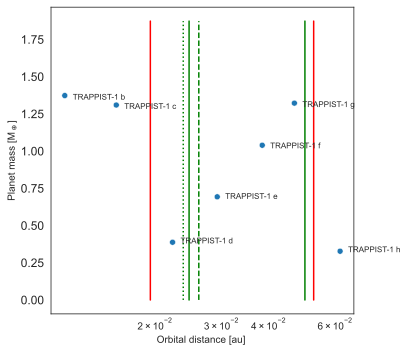

In [13]:
workingTableExoplanets = workingTableExoplanets_final[workingTableExoplanets_final['star_name'].str.startswith('TRAPPIST-1')].copy()

earth_albedo = 0.306
# fig, ax = plt.subplots(figsize=(7, 7))

# conversion to Earth's radius
radius = workingTableExoplanets["radius"] * radius_coeff
# conversion to Earth's mass
mass = workingTableExoplanets["mass"] * mass_coeff
workingTableExoplanets["luminosity"] = numpy.array(numpy.NaN, dtype=float)
for index, row in workingTableExoplanets.iterrows():
    if not pandas.isnull(row["st_lum"]):
        workingTableExoplanets.at[index, "luminosity"] = 10 ** workingTableExoplanets.at[index, "st_lum"]
    else:
        workingTableExoplanets.at[index, "luminosity"] = (4 * numpy.pi * (workingTableExoplanets.at[index, "star_radius"] * constants.R_sun.value) ** 2 * constants.sigma_sb.value * (workingTableExoplanets.at[index, "star_teff"] ** 4)) / constants.L_sun.value

i_units = "kg m-3"


def label_point(x, y, val, ax):
    a = pandas.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x']*1.05, point['y']*0.98, str(point['val']), fontsize=8, zorder=3)
star_t = workingTableExoplanets["star_teff"]
star_radius = workingTableExoplanets["star_radius"]
planet_distance = workingTableExoplanets["semi_major_axis"]

radius = workingTableExoplanets["radius"] * radius_coeff

mass = workingTableExoplanets["mass"] * mass_coeff
orbital = workingTableExoplanets["period"]
distance = workingTableExoplanets["semi_major_axis"]

recentVenus = numpy.power((workingTableExoplanets["luminosity"] / workingTableExoplanets["st_recentVenus"]), 0.5)
runawayGreenhouse = numpy.power((workingTableExoplanets["luminosity"] / workingTableExoplanets["st_runawayGreenhouse"]), 0.5)
maxGreenhouse = numpy.power((workingTableExoplanets["luminosity"] / workingTableExoplanets["st_maxGreenhouse"]), 0.5)
earlyMars = numpy.power((workingTableExoplanets["luminosity"] / workingTableExoplanets["st_earlyMars"]), 0.5)
half_Earth = numpy.power((workingTableExoplanets["luminosity"] / workingTableExoplanets["st_half_Earth"]), 0.5)
five_Earth = numpy.power((workingTableExoplanets["luminosity"] / workingTableExoplanets["st_five_Earth"]), 0.5)
seaborn.set_style("white")

cmap = seaborn.cubehelix_palette(rot=-.2, as_cmap=True)
g = seaborn.relplot(
        facet_kws=dict(despine=False),
        x=distance, y=mass,
        palette=cmap,
    )
plt.ylabel(r"Planet mass [M$_\oplus$]")
plt.xlabel(r"Orbital distance [au] ")
# plottong HZ edges
plt.plot([numpy.nanmax(recentVenus), numpy.nanmax(recentVenus)], [0, numpy.nanmax(mass)+0.5], color='r', label="recent Venus")
plt.plot([numpy.nanmax(runawayGreenhouse), numpy.nanmax(runawayGreenhouse)], [0, numpy.nanmax(mass)+0.5], color='g', label="runaway Greenhouse")
plt.plot([numpy.nanmax(half_Earth), numpy.nanmax(half_Earth)], [0, numpy.nanmax(mass)+0.5], color='g', linestyle="dotted", label="0.5 Earth runaway Greenhouse")
plt.plot([numpy.nanmax(five_Earth), numpy.nanmax(five_Earth)], [0, numpy.nanmax(mass)+0.5], color='g', linestyle="dashed", label="5 Earth runaway Greenhouse")
plt.plot([numpy.nanmax(maxGreenhouse), numpy.nanmax(maxGreenhouse)], [0, numpy.nanmax(mass)+0.5], color='g', label="max Greenhouse")
plt.plot([numpy.nanmax(earlyMars), numpy.nanmax(earlyMars)], [0, numpy.nanmax(mass)+0.5], color='r', label="early Mars")

label_point(distance, mass, workingTableExoplanets.index.to_series(name='index'), plt.gca())
plt.tick_params(axis='both', which='major', labelsize=12)
g.set(xscale="log");

,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,tran_flag,ttv_flag,ima_flag,star_spec_type,flag_mE,flag_rE,mass_detection_type,radius_detection_type,semi_major_axis,semi_major_axis_error_min,semi_major_axis_error_max,pl_orbsmaxlim,period,period_error_min,period_error_max,pl_orbperlim,eccentricity,inclination,star_teff,star_radius,star_mass,star_age,star_metallicity,st_metratio,st_lum,sy_snum,st_rotp,sy_pnum,cb_flag,ra,sy_dist,st_recentVenus,st_runawayGreenhouse,st_maxGreenhouse,st_earlyMars,st_half_Earth,st_five_Earth,age_flame,logg_gspphot,mass_flame,mh_gspphot,radius_gspphot,teff_gspphot,ew_espels_halpha,ew_espels_halpha_model,luminosity
granule_uid,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
KOI-351 g,KOI-351,0.80000,NaN,NaN,1.0,0.689,0.018,-0.018,NaN,NaN,1.0,NaN,NaN,nan,False,False,,,0.716852,0.08000,-0.08000,NaN,210.603111,0.000181,-0.000181,NaN,NaN,90.000,6031.13,1.25,1.11,0.53,0.083,[M/H],0.269,1.0,NaN,8.0,NaN,284.433464,848.254,1.831016,1.141308,0.371551,0.333979,1.224913,1.021123,6.977082,4.2493,1.047091,-0.1199,1.2041,5885.366211,0.264230,0.131131,1.857804
KOI-351 h,KOI-351,1.20000,NaN,NaN,1.0,1.004,0.027,-0.027,NaN,NaN,1.0,NaN,NaN,nan,False,False,,,0.970206,0.11000,-0.11000,NaN,331.601108,0.000246,-0.000246,NaN,NaN,89.990,6031.13,1.25,1.11,0.53,0.083,[M/H],0.269,1.0,NaN,8.0,NaN,284.433464,848.254,1.831016,1.141308,0.371551,0.333979,1.224913,1.021123,6.977082,4.2493,1.047091,-0.1199,1.2041,5885.366211,0.264230,0.131131,1.857804
TRAPPIST-1 h,TRAPPIST-1,0.00103,0.00006,-0.00006,NaN,0.067,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,,0.061890,0.00053,-0.00053,NaN,18.772866,0.000214,-0.000214,NaN,0.00567,89.805,2566.00,0.12,0.09,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174,0.000553
TRAPPIST-1 e,TRAPPIST-1,0.00218,0.00007,-0.00007,NaN,0.082,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,,0.029250,0.00250,-0.00250,NaN,6.101013,0.000035,-0.000035,NaN,0.00510,89.793,2566.00,0.12,0.09,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174,0.000553
TRAPPIST-1 g,TRAPPIST-1,0.00416,0.00012,-0.00012,NaN,0.101,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,,0.046830,0.00040,-0.00040,NaN,12.352446,0.000054,-0.000054,NaN,0.00208,89.742,2566.00,0.12,0.09,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174,0.000553
TRAPPIST-1 d,TRAPPIST-1,0.00122,0.00004,-0.00004,NaN,0.070,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,,0.022270,0.00019,-0.00019,NaN,4.049219,0.000026,-0.000026,NaN,0.00837,89.896,2566.00,0.12,0.09,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174,0.000553
TRAPPIST-1 f,TRAPPIST-1,0.00327,0.00010,-0.00010,NaN,0.093,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,,0.038490,0.00033,-0.00033,NaN,9.207540,0.000032,-0.000032,NaN,0.01007,89.740,2566.00,0.12,0.09,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174,0.000553
TRAPPIST-1 b,TRAPPIST-1,0.00432,0.00022,-0.00022,NaN,0.100,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,,0.011540,0.00010,-0.00010,NaN,1.510826,0.000006,-0.000006,NaN,0.00622,89.728,2566.00,0.12,0.09,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174,0.000553
TRAPPIST-1 c,TRAPPIST-1,0.00412,0.00018,-0.00018,NaN,0.098,0.001,-0.001,NaN,NaN,1.0,1.0,NaN,nan,False,False,,,0.015800,0.00013,-0.00013,NaN,2.421937,0.000018,-0.000018,NaN,0.00654,89.778,2566.00,0.12,0.09,0.50,0.053,[Fe/H],-3.257,1.0,1.4,7.0,NaN,

,massJ,radiusJ,distanceAU,sun_temp
Mercury,0.000174,0.034124,0.387,5777.0
Venus,0.002565,0.084655,0.723,5777.0
Earth,0.003147,0.089215,1.000,5777.0
Mars,0.000338,0.047517,1.524,5777.0
Jupiter,1.000000,1.000000,5.203,5777.0
Saturn,0.299430,0.814520,9.555,5777.0
Uranus,0.045626,0.357533,19.218,5777.0
Neptune,0.054135,0.346412,30.110,5777.0


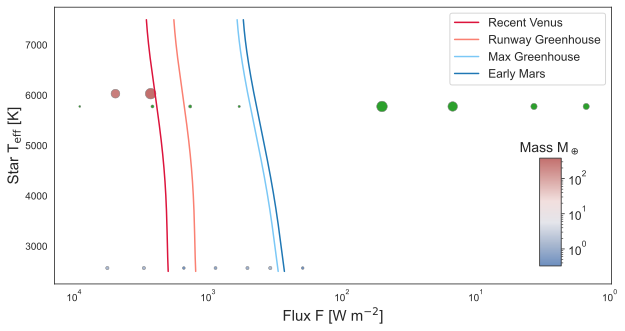

In [18]:
from matplotlib.colors import LogNorm
from matplotlib.colors import LinearSegmentedColormap
workingTableExoplanets = workingTableExoplanets_final
for index, row in workingTableExoplanets.iterrows():
    if not pandas.isnull(row["semi_major_axis"]):
        continue
    else:
        if not pandas.isnull(row["period"]):
            workingTableExoplanets.at[index, "semi_major_axis"] = numpy.power((workingTableExoplanets.at[index, "star_mass"] * constants.M_sun) * constants.G/(4 * numpy.pi **2) * ((workingTableExoplanets.at[index, "period"]* 86400 * units.s) ** 2 ) , 1/3) / constants.au

i_units = "kg m-3"
radius = workingTableExoplanets["radius"] * radius_coeff
mass = workingTableExoplanets["mass"] * mass_coeff
orbital = workingTableExoplanets["period"]
star_teff = workingTableExoplanets["star_teff"]
star_radius = workingTableExoplanets["star_radius"]
planet_distance = workingTableExoplanets["semi_major_axis"]
earth_albedo = 0.306

workingTableExoplanets["luminosity"] = numpy.array(numpy.NaN, dtype=float)
for index, row in workingTableExoplanets.iterrows():
    if not pandas.isnull(row["st_lum"]):
        workingTableExoplanets.at[index, "luminosity"] = 10 ** workingTableExoplanets.at[index, "st_lum"]
    else:
        workingTableExoplanets.at[index, "luminosity"] = (4 * numpy.pi * (workingTableExoplanets.at[index, "star_radius"] * constants.R_sun.value) ** 2 * constants.sigma_sb.value * (workingTableExoplanets.at[index, "star_teff"] ** 4)) / constants.L_sun.value
l_units = units.Quantity(1,'W m-2')
planet_flux = workingTableExoplanets["luminosity"] * constants.L_sun / (4 * numpy.pi * (workingTableExoplanets["semi_major_axis"] * constants.au) ** 2)

with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(workingTableExoplanets)
# print(max(mass), max(radius))
norm = LogNorm(mass.min(), mass.max())

cmap=LinearSegmentedColormap.from_list("",seaborn.color_palette("vlag"))

fig, ax = plt.subplots(figsize=(10, 5))

solarsystemTable = pandas.read_pickle("./solarsystem.pkl")
with pandas.option_context('display.max_rows', None, 'display.max_columns', None):
    display(solarsystemTable)
massS = solarsystemTable["massJ"] * mass_coeff
radiusS = solarsystemTable["radiusJ"] * radius_coeff

fluxS =  1. * constants.L_sun / (4 * numpy.pi * (solarsystemTable["distanceAU"] * constants.au) ** 2)

solarsysS = ax.scatter(fluxS, solarsystemTable["sun_temp"],
                       s=radiusS * 10, marker="o", facecolor='tab:green', edgecolor="tab:gray", linewidths=0.5)

im = ax.scatter(
    planet_flux, star_teff, c=mass, cmap=cmap, norm=matplotlib.colors.LogNorm(), s=radius * 10,
    zorder=1, marker="o", facecolor="b", edgecolor="tab:gray",linewidths=0.5
)

levelsZ = ["Recent Venus", "Runaway Greenhouse", "max Greenhouse", "Early Mars", "0.5 Earth", "10 Earth",]
colors=["#DC143C", "#FA8072", "#7BC8F6", "#1f77b4",'#008000', '#15B01A' ]
star_teffl = numpy.linspace(2500,7500,2000)

seffsun  = [1.776, 1.107, 0.356, 0.320, 1.188, 0.99]
a = [2.136e-4, 1.332e-4, 6.171e-5, 5.547e-5, 1.433e-4, 1.209e-4]
b = [2.533e-8, 1.580e-8, 1.698e-9, 1.526e-9, 1.707e-8, 1.404e-8]
c = [-1.332e-11, -8.308e-12, -3.198e-12, -2.874e-12, -8.968e-12, -7.418e-12]
d = [-3.097e-15, -1.931e-15, -5.575e-16, -5.011e-16, -2.084e-15, -1.713e-15]

recent_venus  = seffsun[0] + a[0] * (star_teffl - 5780.0) + b[0] * (star_teffl - 5780.0) ** 2 + c[0] * (star_teffl - 5780.0) ** 3 + d[0] * (star_teffl - 5780.0) ** 4
runway_greenhouse  = seffsun[1] + a[1] * (star_teffl - 5780.0) + b[1] * (star_teffl - 5780.0) ** 2 + c[1] * (star_teffl - 5780.0) ** 3 + d[1] * (star_teffl - 5780.0) ** 4
max_greenhouse  = seffsun[2] + a[2] * (star_teffl - 5780.0) + b[2] * (star_teffl - 5780.0) ** 2 + c[2] * (star_teffl - 5780.0) ** 3 + d[2] * (star_teffl - 5780.0) ** 4
early_mars = seffsun[3] + a[3] *(star_teffl - 5780.0) + b[3] * (star_teffl - 5780.0) ** 2 + c[3] * (star_teffl - 5780.0) ** 3 + d[3] * (star_teffl - 5780.0) ** 4
half_Earth  = seffsun[4] + a[4] * (star_teffl - 5780.0) + b[4] * (star_teffl - 5780.0) ** 2 + c[4] * (star_teffl - 5780.0) ** 3 + d[4] * (star_teffl - 5780.0) ** 4
five_Earth  = seffsun[5] + a[5] * (star_teffl - 5780.0) + b[5] * (star_teffl - 5780.0) ** 2 + c[5] * (star_teffl - 5780.0) ** 3 + d[5] * (star_teffl - 5780.0) ** 4

ax.plot(recent_venus * fluxS[2], star_teffl, color = colors[0], label="Recent Venus")
ax.plot(runway_greenhouse * fluxS[2], star_teffl, color = colors[1], label="Runway Greenhouse")
ax.plot(max_greenhouse * fluxS[2], star_teffl,color = colors[2], label="Max Greenhouse")
ax.plot(early_mars * fluxS[2], star_teffl,color = colors[3], label="Early Mars")

plt.grid(False)

ax.set_xscale('log')

ax.set_xlim(ax.get_xlim()[::-1])

ax.tick_params(top=False)
ax.tick_params(labeltop=False)
ax.tick_params(right=False)
ax.tick_params(labelright=False)

ax.set_xlabel(r"Flux F [W m$^{-2}$]",fontsize=15)#/F$_\oplus$")
ax.set_ylabel(r"Star T$_\mathrm{eff}$ [K]", fontsize=15)

norm = LogNorm(mass.min(), mass.max())

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])

cax = fig.add_axes([.8, 0.16, 0.03, 0.3])
cax.figure.colorbar(sm, cax=cax)

cax.patch.set_facecolor('white')
cax.patch.set_alpha(0.)
cax.set_title(r'Mass M$_\oplus$', fontsize=14)
ax.legend(loc="upper right", prop={"size":12})

plt.tick_params(axis='both', which='major', labelsize=12)


You can additionally check if, in your sample, there are systems with at least two planets having masses and radii determined and the planets are neighbours. 


In [14]:
def hasTwoConsecutiveWithMassAndRadius(pickle, starName):
    #print("---")
    cnt = 0
    for index, row in workingTableExoplanets_final.query("star_name == @starName").sort_values(by=["period"]).iterrows():
        #print(index, row["mass"], row["radius"], row["period"])
        if pandas.notnull(row["mass"]) and pandas.notnull(row["radius"]):
            cnt += 1
        else:
            cnt = 0
        if cnt >= 2:
            return True
    return False

stars = workingTableExoplanets_final["star_name"].unique()
print(f"Total systems: {len(stars)}")

starsWithTwoOrMoreConsecitive = []
for star in stars:
    if hasTwoConsecutiveWithMassAndRadius(workingTableExoplanets_final, star):
        starsWithTwoOrMoreConsecitive.append(star)
    # else:
    #     print(f"- {star} has no two consecutive")
print(f"Systems with two consecutive: {len(starsWithTwoOrMoreConsecitive)}")
planetstodrop=[]
for index, row in workingTableExoplanets_final.iterrows():
    if not row["star_name"] in starsWithTwoOrMoreConsecitive:
        planetstodrop.append(index)
exoTable = workingTableExoplanets_final.drop(index=planetstodrop)

display(exoTable)

Total systems: 2
Systems with two consecutive: 2


,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,...,sy_pnum,cb_flag,ra,sy_dist,st_recentVenus,st_runawayGreenhouse,st_maxGreenhouse,st_earlyMars,st_half_Earth,st_five_Earth
granule_uid,,,,,,,,,,,,,,,,,,,,,
KOI-351 g,KOI-351,0.80000,NaN,NaN,1.0,0.689,0.018,-0.018,NaN,NaN,...,8.0,NaN,284.433464,848.254,1.831016,1.141308,0.371551,0.333979,1.224913,1.021123
KOI-351 h,KOI-351,1.20000,NaN,NaN,1.0,1.004,0.027,-0.027,NaN,NaN,...,8.0,NaN,284.433464,848.254,1.831016,1.141308,0.371551,0.333979,1.224913,1.021123
TRAPPIST-1 h,TRAPPIST-1,0.00103,0.00006,-0.00006,NaN,0.067,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 e,TRAPPIST-1,0.00218,0.00007,-0.00007,NaN,0.082,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 g,TRAPPIST-1,0.00416,0.00012,-0.00012,NaN,0.101,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 d,TRAPPIST-1,0.00122,0.00004,-0.00004,NaN,0.070,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 f,TRAPPIST-1,0.00327,0.00010,-0.00010,NaN,0.093,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 b,TRAPPIST-1,0.00432,0.00022,-0.00022,NaN,0.100,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950
TRAPPIST-1 c,TRAPPIST-1,0.00412,0.00018,-0.00018,NaN,0.098,0.001,-0.001,NaN,NaN,...,7.0,NaN,346.626392,NaN,1.462902,0.911885,0.221890,0.199430,0.979128,0.809950


If you run scripts in terminal, you need to concatenate all chosen system files into one, which certain Jupyter notebooks will be working with. This combined file in `.pkl` format will also be needed for creating working files for internal systems structure analyses. You can do the concatenation by running the `5-merge-edges.py` script (*after putting the `.pkl` files of interest into the `./merging/` folder*):

``` sh
$ mkdir ./merging
$ cp ./data/star_pickles_enriched/*.pkl ./merging/
$ python ./5-merge-edges.py
```

Results will be saved to `./data/all_my_systems.pkl`.

But in this notebook we have already assembled a sample with all fields that we need. Now we can retrieve additional information from other databases, for example from Gaia.
For that we will use modul  `uio.tasks.reconfirming_stellar_parameters`

The cell below does reconfirm stellar parameters and enrich original datasets with additional data from Gaia DR3 release [Fouesneau et al., 2022](#Fouesneau).
For explanation of this parameters we refer to [Andrae et al., 2022](#Andrae). Then the module writes the retrieved data in the same table, which will be displayed or saved in `pkl` file at the end.

In [15]:
from uio.utility.files import pickle
from uio.tasks import reconfirming_stellar_parameters

originalTable = workingTableExoplanets_final
# originalTable = pickle.openPickleAsPandasTable("./data/your_own_sample.pkl")
tbl = reconfirming_stellar_parameters.lookForParametersInGaia(
    originalTable,
    "gaiadr3.astrophysical_parameters",
    [
        "age_flame",
        "logg_gspphot",
        "mass_flame",
        "mh_gspphot",
        "radius_gspphot",
        "teff_gspphot",
        "ew_espels_halpha",
        "ew_espels_halpha_model"
    ],
    "dr3"
)
display(workingTableExoplanets_final)


Getting GAIA IDs from SIMBAD...

- found GAIA ID for [KOI-351]: 2132193431285570304
- found GAIA ID for [TRAPPIST-1]: 2635476908753563008

Looking for parameters in GAIA...

- KOI-351 | 2132193431285570304...
- TRAPPIST-1 | 2635476908753563008...

Found parameters for 2/2 stars



,star_name,mass,mass_error_min,mass_error_max,pl_massjlim,radius,radius_error_min,radius_error_max,pl_radjlim,rv_flag,...,st_half_Earth,st_five_Earth,age_flame,logg_gspphot,mass_flame,mh_gspphot,radius_gspphot,teff_gspphot,ew_espels_halpha,ew_espels_halpha_model
granule_uid,,,,,,,,,,,,,,,,,,,,,
KOI-351 g,KOI-351,0.80000,NaN,NaN,1.0,0.689,0.018,-0.018,NaN,NaN,...,1.224913,1.021123,6.977082,4.2493,1.047091,-0.1199,1.2041,5885.366211,0.264230,0.131131
KOI-351 h,KOI-351,1.20000,NaN,NaN,1.0,1.004,0.027,-0.027,NaN,NaN,...,1.224913,1.021123,6.977082,4.2493,1.047091,-0.1199,1.2041,5885.366211,0.264230,0.131131
TRAPPIST-1 h,TRAPPIST-1,0.00103,0.00006,-0.00006,NaN,0.067,0.001,-0.001,NaN,NaN,...,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174
TRAPPIST-1 e,TRAPPIST-1,0.00218,0.00007,-0.00007,NaN,0.082,0.001,-0.001,NaN,NaN,...,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174
TRAPPIST-1 g,TRAPPIST-1,0.00416,0.00012,-0.00012,NaN,0.101,0.001,-0.001,NaN,NaN,...,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174
TRAPPIST-1 d,TRAPPIST-1,0.00122,0.00004,-0.00004,NaN,0.070,0.001,-0.001,NaN,NaN,...,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174
TRAPPIST-1 f,TRAPPIST-1,0.00327,0.00010,-0.00010,NaN,0.093,0.001,-0.001,NaN,NaN,...,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174
TRAPPIST-1 b,TRAPPIST-1,0.00432,0.00022,-0.00022,NaN,0.100,0.001,-0.001,NaN,NaN,...,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174
TRAPPIST-1 c,TRAPPIST-1,0.00412,0.00018,-0.00018,NaN,0.098,0.001,-0.001,NaN,NaN,...,0.979128,0.809950,NaN,NaN,NaN,NaN,NaN,NaN,-0.660257,-1.193174


References:

Kopparapu, R. K., Ramirez, R. M., SchottelKotte, J., Kasting, J. F., Domagal-Goldman, S. and Eymet, V. (2014). "Habitable zones around main-sequence stars: dependence
on planetary mass". In: The Astrophysical Journal Letters vol. 787, no. 2, p. L29.

Mamonova et al. (2024) "Planets similar in size are often dissimilar in interior ", acceppted. In: Astronomy\&Astrophysics.

Andrae, R. et al. (2022) ‘Gaia Data Release 3: Analysis of the Gaia BP/RP spectra using the General Stellar Parameterizer from Photometry’, Astronomy & Astrophysics [Preprint]. Available at: https://doi.org/10.1051/0004-6361/202243462.

Fouesneau, M. et al. (2022) ‘Gaia Data Release 3. Apsis II: Stellar parameters’, Astronomy & Astrophysics [Preprint]. Available at: https://doi.org/10.1051/0004-6361/202243919.
